## Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить:

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД
* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

* Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

## Загрузим нужные библиотеки


In [1]:
# import all required libs
import requests
import time
from datetime import datetime
from pprint import pprint
import pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams


## Создадим нужные классы

In [2]:
class DomRFObjects:

    def __init__(self):
        self.offset = 0
        self.limit = 1000
        self.length = 1
        self.buildings = []
        
    def get_buildings(self):
        session = requests.Session()
        retry = Retry(connect=3, backoff_factor=0.5)
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)
        while self.length > 0:
            start = datetime.now()
            object_list = []
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset}&limit={self.limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            res = session.get(url)
            res_json = res.json()
            for i in res_json['data']['list']:
                object_list.append(i['objId'])
            self.offset += self.limit
            self.length = len(res_json['data']['list'])
            for i in object_list:
                url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{i}'
                res = session.get(url)
                res_json = res.json()
                self.buildings.append(res_json)
            finish = datetime.now()
            print(f'Кол-во выгруженных домов в датасет - {len(self.buildings)}', f'время выполнения прохода - {finish - start}')
    def get_length(self):
        print(f'Количество домов в датасете: {len(self.buildings)}')
    def get_data_slice(self, size = 5):
        self.size = size
        return self.buildings[:size]


In [3]:
class DfCreator:

    def __init__(self, data):
        self.df = pd.json_normalize(data)
    
    def create_excel(self, excel_name):
        self.excel_name = excel_name
        self.df.to_excel(f'{self.excel_name}.xlsx')
             
    def create_pickle(self, pickle_name):
        self.pickle_name = pickle_name
        self.df.to_pickle(f'{pickle_name}.pkl')

    def create_db(self, db_name):
        self.db_name = db_name
        con = sqlite3.connect(f'{self.db_name}.db')
        self.df1 = self.df.applymap(str)
        self.df1.to_sql(f'{self.db_name}', con, if_exists = 'replace')
        con.commit()
        con.close()

In [4]:
class DfCorrect:

    def __init__(self, data):
        self.df = data
            
    def rename_columns(self):
        self.new_column_list = {}
        self.old_columns = self.df.columns
        for col in self.old_columns:
            if len(col.split('.')) >= 2:
                self.new_column_list[col] = "_".join(col.split('.')[1:])
        self.df.rename(columns = self.new_column_list, inplace = True)   
        
    def get_limitcols(self, cols):
        self.cols = cols
        self.df = self.df[self.cols]
        self.df = self.df.copy()
        self.df.dropna(inplace = True)
        
    def correct_date(self):
        self.df['objReady100PercDt'] = pd.to_datetime(self.df['objReady100PercDt'])

In [5]:
class VisualCreator:
    
    def __init__(self, data):
        self.df = data
        sns.set(style='darkgrid')  
    def plot_barh(self, x_axes, y_axes, aggf = 'mean', title = None):
        self.x_axes = x_axes
        self.y_axes = y_axes
        self.aggf = aggf
        self.title = title
        from pylab import rcParams
        rcParams['figure.figsize'] = 9,20
        if self.aggf == 'mean':
            self.df.groupby(self.x_axes)[self.y_axes].mean().sort_values(ascending = True).plot(kind = 'barh', color = 'Green')
        elif self.aggf == 'sum':
            self.df.groupby(self.x_axes)[self.y_axes].sum().sort_values(ascending = True).plot(kind = 'barh', color = 'Green')
        elif self.aggf == 'min':
            self.df.groupby(self.x_axes)[self.y_axes].min().sort_values(ascending = True).plot(kind = 'barh', color = 'Green')
        elif self.aggf == 'max':
            self.df.groupby(self.x_axes)[self.y_axes].max().sort_values(ascending = True).plot(kind = 'barh', color = 'Green')
        elif self.aggf == 'count':
            self.df.groupby(self.x_axes)[self.y_axes].sum().sort_values(ascending = True).plot(kind = 'barh', color = 'Green')    
        else:
            print('Incorrect aggregate function')
        
        if self.title == None:
            plt.title(f'Dependancy of {self.aggf} {self.y_axes} from {self.x_axes}')
        else:
            plt.title(f'{self.title}')
        plt.show()
    
    def plot_line(self, x_axes, y_axes, aggf = 'mean', title = None):
        self.x_axes = x_axes
        self.y_axes = y_axes
        self.aggf = aggf
        self.title = title

        if self.aggf == 'mean':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].mean().reset_index()
        elif self.aggf == 'count':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].count().reset_index()
        elif self.aggf == 'min':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].min().reset_index()
        elif self.aggf == 'max':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].max().reset_index()
        elif self.aggf == 'sum':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].sum().reset_index()       
        else:
            print('Incorrect aggregate function')
        sns.relplot(x=self.x_axes,
                y=self.y_axes,
                data=self.df1,
                aspect=4,
                kind='line',
                color = 'g'
                )
        plt.xticks(rotation=90)
        if self.title == None:
            plt.title(f'Dependancy of {self.aggf} {self.y_axes} from {self.x_axes}')
        else:
            plt.title(f'{self.title}')
            
    def plot_barv(self, x_axes, y_axes, aggf = 'mean', title = None):
        self.x_axes = x_axes
        self.y_axes = y_axes
        self.aggf = aggf
        self.title = title

        if self.aggf == 'mean':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].mean().reset_index()
        elif self.aggf == 'count':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].count().reset_index()
        elif self.aggf == 'min':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].min().reset_index()
        elif self.aggf == 'max':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].max().reset_index()
        elif self.aggf == 'sum':
            self.df1 = self.df.groupby(self.x_axes)[y_axes].sum().reset_index()       
        else:
            print('Incorrect aggregate function')
        rcParams['figure.figsize'] = 20.7,8.27
        sns.barplot(x=self.x_axes,
                    y=self.y_axes,
                    data=self.df1,
                    color = 'g'
                   )
        plt.xticks(rotation=90)
        if self.title == None:
            plt.title(f'Dependancy of {self.aggf} {self.y_axes} from {self.x_axes}')
        else:
            plt.title(f'{self.title}')

#### *Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"*

In [6]:
a = DomRFObjects()

In [7]:
# получим список построек с помощью метода get_buildings в нашем классе
a.get_buildings()

Кол-во выгруженных домов в датасет - 1000 время выполнения прохода - 0:01:31.869926
Кол-во выгруженных домов в датасет - 2000 время выполнения прохода - 0:01:27.240954
Кол-во выгруженных домов в датасет - 3000 время выполнения прохода - 0:01:38.848024
Кол-во выгруженных домов в датасет - 4000 время выполнения прохода - 0:01:29.600809
Кол-во выгруженных домов в датасет - 5000 время выполнения прохода - 0:01:33.502800
Кол-во выгруженных домов в датасет - 6000 время выполнения прохода - 0:01:31.056065
Кол-во выгруженных домов в датасет - 7000 время выполнения прохода - 0:01:33.911521
Кол-во выгруженных домов в датасет - 8000 время выполнения прохода - 0:01:29.430381
Кол-во выгруженных домов в датасет - 9000 время выполнения прохода - 0:01:34.464260
Кол-во выгруженных домов в датасет - 10000 время выполнения прохода - 0:01:29.564467
Кол-во выгруженных домов в датасет - 10562 время выполнения прохода - 0:00:52.296952
Кол-во выгруженных домов в датасет - 10562 время выполнения прохода - 0:00

In [8]:
# проверим количество объектов
a.get_length()

Количество домов в датасете: 10562


In [9]:
# посмотрим информацию об одном объекте
a.get_data_slice(1)

[{'data': {'id': 29679,
   'pdId': 124647,
   'developer': {'devId': 7424,
    'devShortCleanNm': '212-2',
    'devShortNm': '212-2',
    'devFullCleanNm': '212-2',
    'problObjCnt': 0,
    'buildObjCnt': 1,
    'comissObjCnt': 0,
    'regRegionDesc': 'Ростовская область',
    'devPhoneNum': '+7(961)285-90-10',
    'devSite': 'taganrogjsk.wixsite.com',
    'devEmail': 'kirpol76@gmail.com',
    'devInn': '6154572922',
    'devOgrn': '1116154005923',
    'devKpp': '615401001',
    'devLegalAddr': 'Ростовская область, город Таганрог, улица Свободы/Трудовых резервов дом 25/9',
    'devFactAddr': 'обл Ростовская город Таганрог улица Сергея Шило д. 212-2',
    'lastRpdId': 126093,
    'fundGuarantyFlg': 0,
    'devOrgRegRegionCd': 61,
    'devEmplMainFullNm': 'Снимщикова Ольга Викторовна',
    'orgForm': {'id': 20,
     'fullForm': 'Жилищный или жилищно-строительный кооператив',
     'shortForm': 'ЖСК'},
    'objGuarantyEscrowFlg': 0,
    'govFundFlg': 0},
   'region': 61,
   'address': 'г 

#### *Cохранить ее в pandas dataframe, а также в excel, pickle, БД*

In [10]:
# Создаем датафрейм из объекта buildings
b = DfCreator(a.buildings)

In [11]:
# Сохраняем датафрейм в excel
b.create_excel('test')

In [12]:
# Сохраняем датафрейм в pickle
b.create_pickle('test')

In [13]:
# Сохраняем датафрейм в db
b.create_db('test')

#### *Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных*

In [14]:
# Передаем наш датафрейм в класс для обработки
c = DfCorrect(b.df)

In [15]:
# Переименуем колонки
c.rename_columns()

In [16]:
# Оставим в датафрейме только нужные колонки
cols = ['id', 'objPriceAvg', 'developer_regRegionDesc', 'objReady100PercDt', 'objElemLivingCnt', 'floorMax', 'objSquareLiving', 'objElemParkingCnt']
c.get_limitcols(cols)

In [17]:
# Переведем в формат даты
c.correct_date()

In [18]:
# Выведем получившийся датафрейм
c.df

,id,objPriceAvg,developer_regRegionDesc,objReady100PercDt,objElemLivingCnt,floorMax,objSquareLiving,objElemParkingCnt
1,13383,53109.0,Тюменская область,2022-12-31,68,20.0,6293.78,31
2,13397,45523.0,Тюменская область,2024-12-31,65,12.0,6248.51,0
3,13399,50768.0,Тюменская область,2024-12-31,0,1.0,0.00,125
4,13398,47886.0,Тюменская область,2024-12-31,43,10.0,4812.98,0
5,13391,55893.0,Тюменская область,2022-12-31,44,12.0,4297.44,41
...,...,...,...,...,...,...,...,...
10557,28072,85610.0,Московская область,2024-06-30,312,26.0,14788.80,0
10558,28071,85604.0,Московская область,2024-06-30,288,26.0,14870.40,0
10559,28073,85634.0,Московская область,2024-06-30,312,26.0,14872.80,0
10560,44447,69916.0,Ярославская область,2022-12-31,127,6.0,6764.22,0


#### *Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.*

In [19]:
# Передадим наш датафрейм в класс с визуализацией 
d = VisualCreator(c.df)

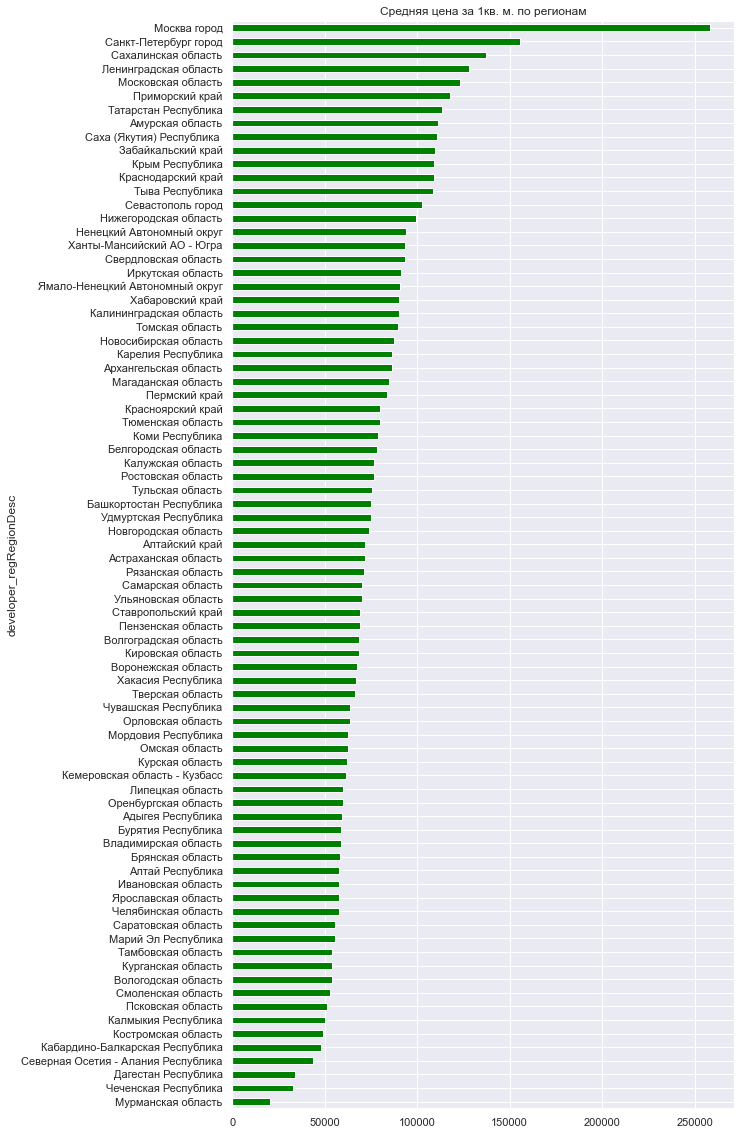

In [20]:
# Построим график со средними ценами за квадрат 
d.plot_barh('developer_regRegionDesc', 'objPriceAvg', 'mean', 'Средняя цена за 1кв. м. по регионам')

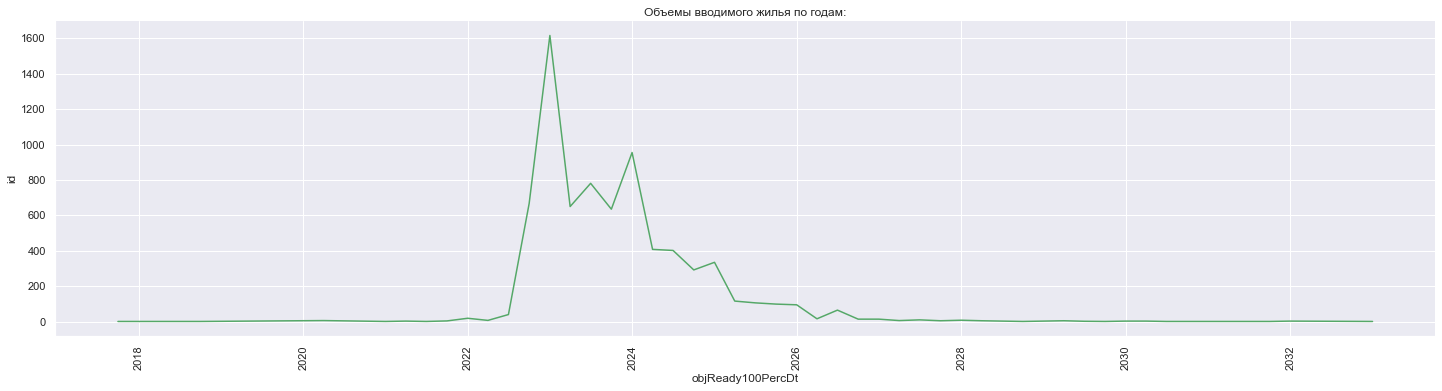

In [21]:
# Построим объемы вводимого жилья по годам
d.plot_line('objReady100PercDt', 'id', 'count', 'Объемы вводимого жилья по годам:')

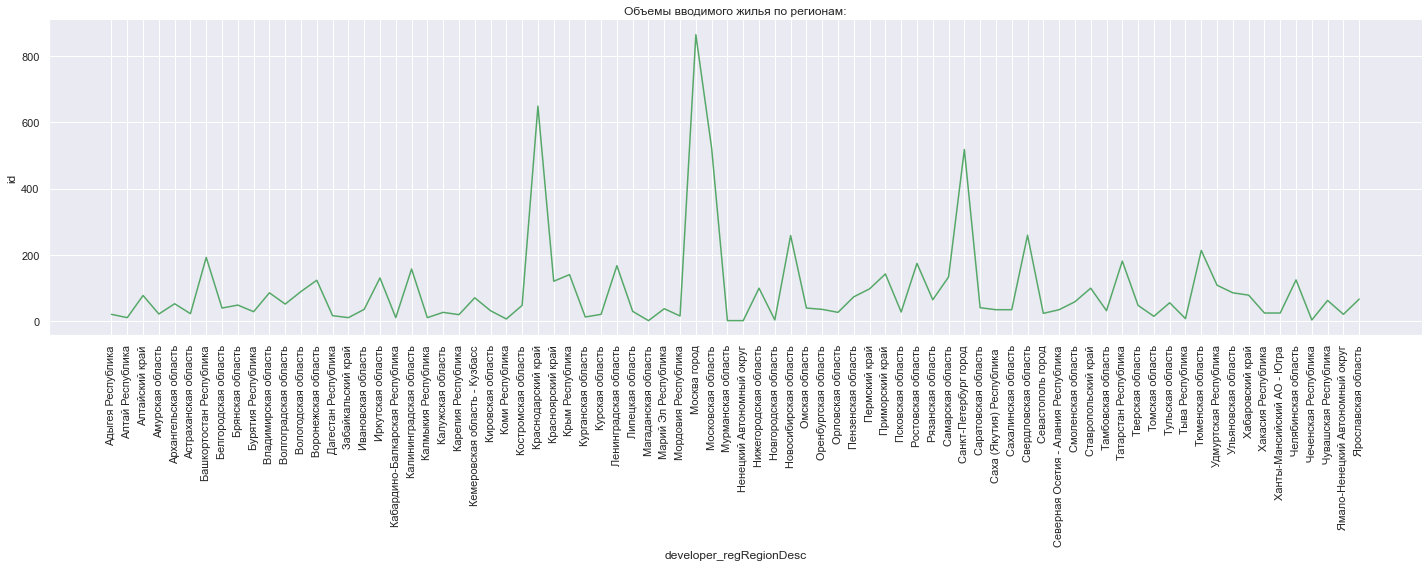

In [22]:
# Построим объемы вводимого жилья по регионам
d.plot_line('developer_regRegionDesc', 'id', 'count', 'Объемы вводимого жилья по регионам:')

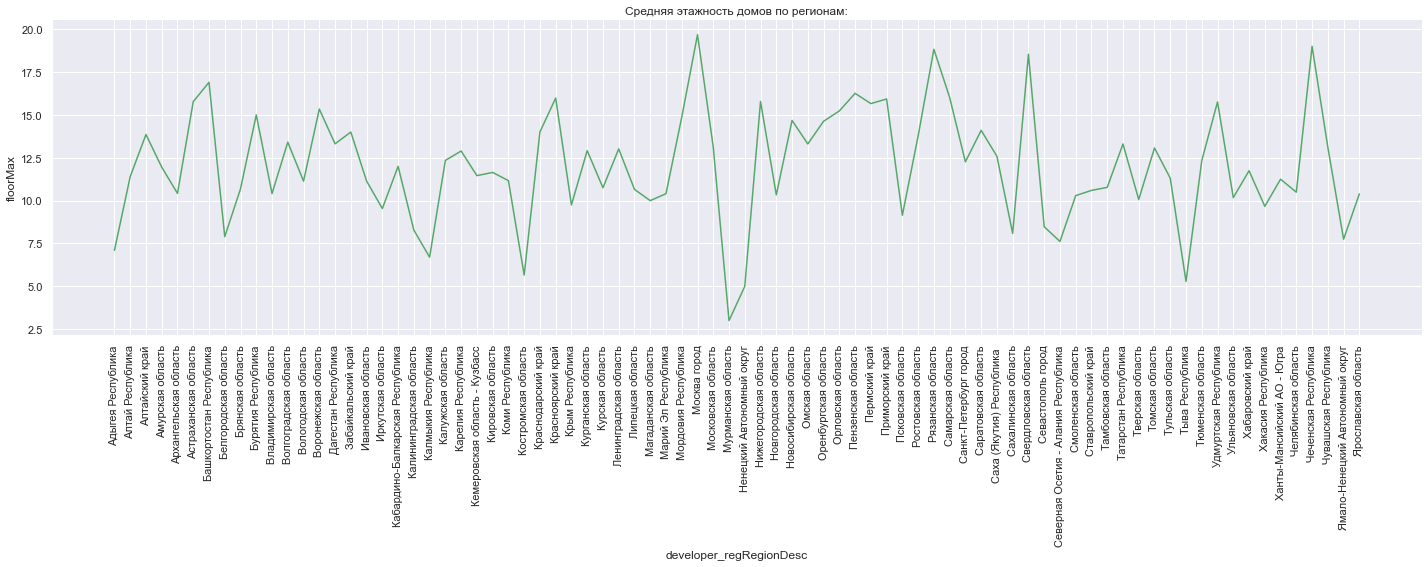

In [23]:
# Построим среднюю этажность домов по регионам
d.plot_line('developer_regRegionDesc', 'floorMax', 'mean', 'Средняя этажность домов по регионам:')

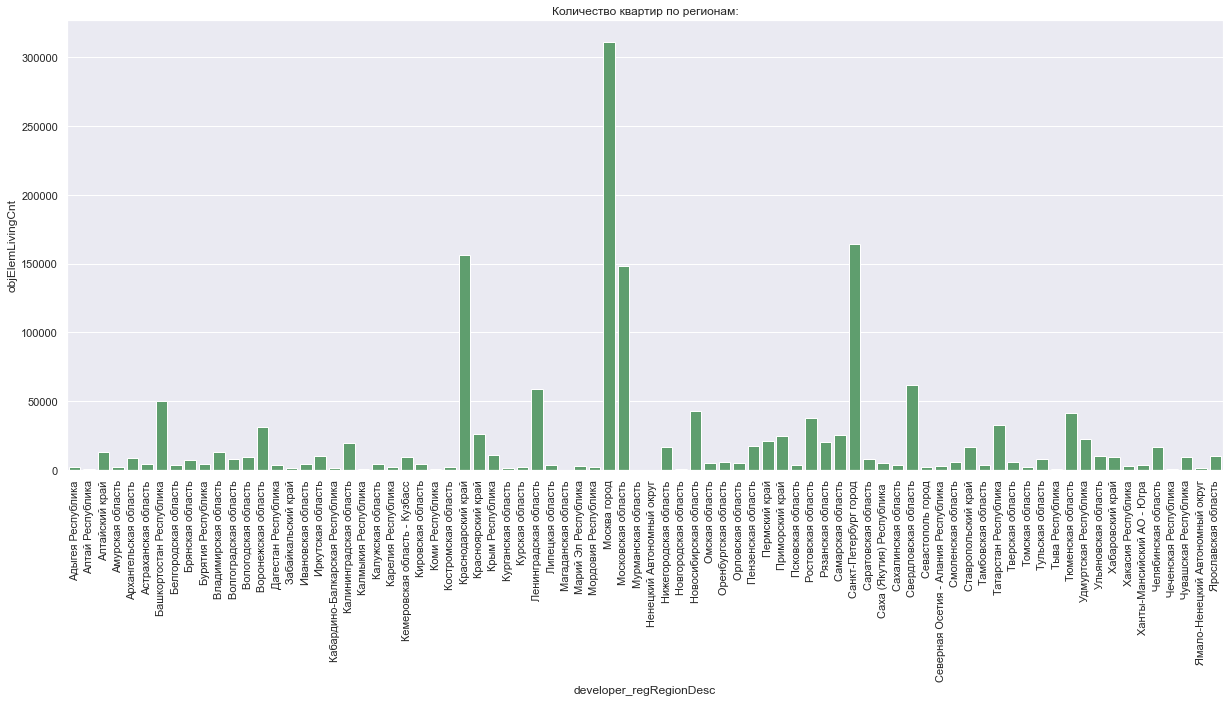

In [24]:
# Построим количество квартир по регионам:
d.plot_barv('developer_regRegionDesc', 'objElemLivingCnt', 'sum', 'Количество квартир по регионам:')

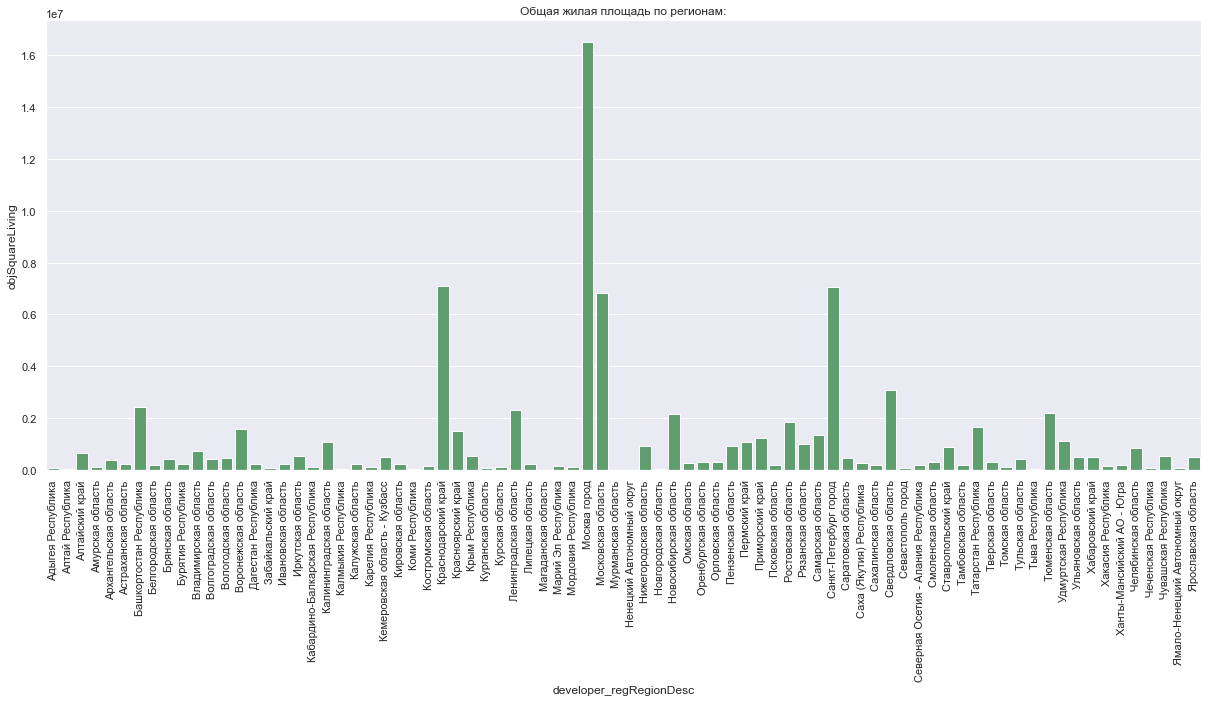

In [25]:
# Построим общая жилая площадь по регионам:
d.plot_barv('developer_regRegionDesc', 'objSquareLiving', 'sum', 'Общая жилая площадь по регионам:')

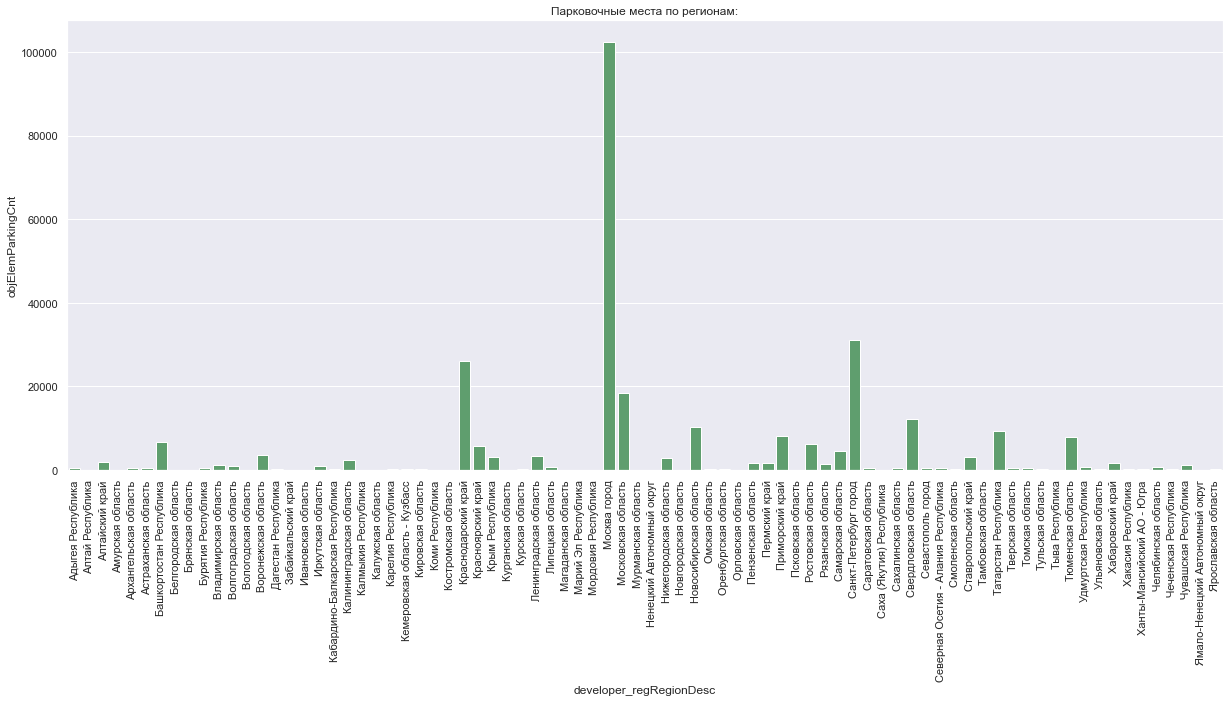

In [26]:
# Построим парковочные места по регионам:
d.plot_barv('developer_regRegionDesc', 'objElemParkingCnt', 'sum', 'Парковочные места по регионам:')

### *Выводы*

При высоких ценах на квадратный метр в Москве и Санкт-Петербурге хорошо организованны парковочные места. Плюс спрос на жилье в Москве и Питере высокий.
Так же мы видим Краснодарский край, где есть колосальный спрос на жилье, но при этом цены на квадратный метр еще не такие высокие. Это говорит об инвестиционной привлекательности региона.
Основной выпуск жилья нацелен на 23й и 24й годы.